# Network Construction and Analysis

## Goal
Build a **user similarity network** from viewing behavior and analyze its properties using standard complex network metrics.

## Network Definition
- **Nodes:** Users (N = 1,411)
- **Edges:** Connect users with similar viewing patterns
- **Edge criterion:** Cosine similarity of watch_ratio vectors > threshold
- **Network type:** Undirected, weighted (similarity as weight)

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data and Create User-Video Matrix

We need a matrix where:
- Rows = users
- Columns = videos
- Values = watch_ratio (how much of each video the user watched)

This matrix captures each user's "viewing profile" across all videos.

In [2]:
# Load interaction data
print("Loading interaction data...")
interactions = pd.read_csv('data/raw/small_matrix.csv')

print(f"Total interactions: {len(interactions):,}")
print(f"Unique users: {interactions['user_id'].nunique():,}")
print(f"Unique videos: {interactions['video_id'].nunique():,}")

# Create user-video matrix
print("\nCreating user-video matrix...")
user_video_matrix = interactions.pivot_table(
    index='user_id',
    columns='video_id',
    values='watch_ratio',
    fill_value=0  # If user didn't watch, assume 0 (rare with 99.7% coverage)
)

print(f"Matrix shape: {user_video_matrix.shape[0]:,} users × {user_video_matrix.shape[1]:,} videos")
print(f"\nSample of user-video matrix:")
print(user_video_matrix.iloc[:5, :5])

Loading interaction data...
Total interactions: 4,676,570
Unique users: 1,411
Unique videos: 3,327

Creating user-video matrix...
Matrix shape: 1,411 users × 3,327 videos

Sample of user-video matrix:
video_id       103       109       120       122       128
user_id                                                   
14        0.429126  1.482039  0.728738  0.477810  0.439333
19        0.624466  1.070684  1.006064  0.759092  0.882691
21        1.415049  1.028840  1.809125  0.688823  0.588365
23        0.169223  2.549891  0.247487  0.438669  0.114338
24        0.345049  0.449337  0.802936  0.797411  1.875599


## 2. Compute User Similarity

**Cosine similarity** measures how similar two users' viewing patterns are:
- 1.0 = identical viewing behavior
- 0.0 = completely different

Formula: $\text{similarity}(u_i, u_j) = \frac{\vec{v}_i \cdot \vec{v}_j}{||\vec{v}_i|| \, ||\vec{v}_j||}$

where $\vec{v}_i$ is user i's watch_ratio vector across all videos.

Computing pairwise user similarity...
(This may take a minute for 1,411 users)

Similarity matrix shape: (1411, 1411)
  (1,411 users × 1,411 users)

Similarity statistics (all 1,989,510 user pairs):
  Mean:   0.5710
  Median: 0.5750
  Std:    0.2036
  Min:    0.0228
  Max:    0.9935


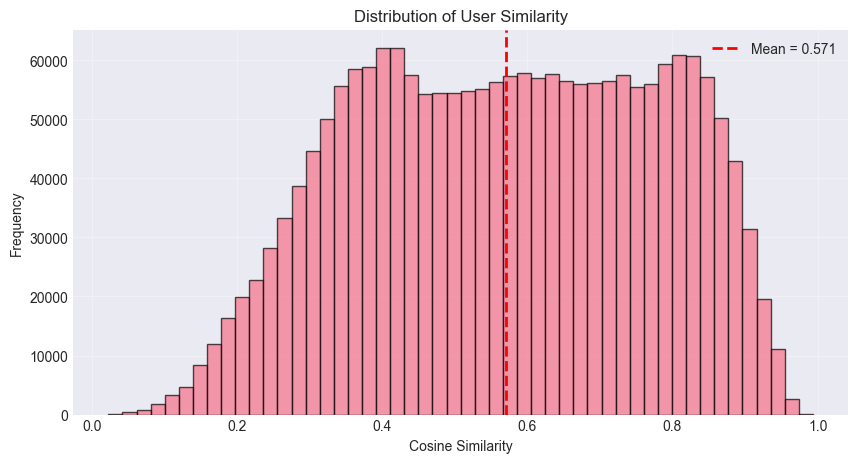

In [3]:
# Compute pairwise cosine similarity between all users
print("Computing pairwise user similarity...")
print("(This may take a minute for 1,411 users)\n")

similarity_matrix = cosine_similarity(user_video_matrix.values)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"  ({similarity_matrix.shape[0]:,} users × {similarity_matrix.shape[1]:,} users)")

# Convert to DataFrame for easier handling
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_video_matrix.index,
    columns=user_video_matrix.index
)

# Set diagonal to NaN (user's similarity with themselves = 1.0, not interesting)
np.fill_diagonal(similarity_matrix, np.nan)

# Analyze similarity distribution
similarities = similarity_matrix[~np.isnan(similarity_matrix)]

print(f"\nSimilarity statistics (all {len(similarities):,} user pairs):")
print(f"  Mean:   {np.mean(similarities):.4f}")
print(f"  Median: {np.median(similarities):.4f}")
print(f"  Std:    {np.std(similarities):.4f}")
print(f"  Min:    {np.min(similarities):.4f}")
print(f"  Max:    {np.max(similarities):.4f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of User Similarity')
plt.axvline(np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(similarities):.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Build Network with Threshold

Create edges only between users with similarity above a threshold.

**Threshold selection:**
- Too low (e.g., 0.3): Too many edges, network too dense
- Too high (e.g., 0.9): Too few edges, network too sparse
- Good range: 0.6 - 0.8

We'll try **threshold = 0.7** (keeping ~30% of edges)

In [4]:
# Choose threshold
THRESHOLD = 0.7

print(f"Building network with similarity threshold = {THRESHOLD}")
print("="*70)

# Create graph
G = nx.Graph()

# Add all users as nodes
users = user_video_matrix.index.tolist()
G.add_nodes_from(users)
print(f"Added {G.number_of_nodes():,} nodes")

# Add edges for user pairs with similarity > threshold
edges_added = 0
for i, user_i in enumerate(users):
    for j, user_j in enumerate(users[i+1:], start=i+1):  # Only upper triangle (undirected)
        sim = similarity_df.loc[user_i, user_j]
        if sim >= THRESHOLD:
            G.add_edge(user_i, user_j, weight=sim)
            edges_added += 1

print(f"Added {edges_added:,} edges (similarity ≥ {THRESHOLD})")

# Network statistics
N = G.number_of_nodes()
E = G.number_of_edges()
max_edges = N * (N - 1) / 2
density = nx.density(G)

print(f"\nNetwork Properties:")
print(f"  Nodes (N):        {N:,}")
print(f"  Edges (E):        {E:,}")
print(f"  Density:          {density:.4f} ({100*density:.2f}%)")
print(f"  Max possible edges: {int(max_edges):,}")
print(f"  Is connected:     {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    largest_cc = max(components, key=len)
    print(f"  Components:       {len(components)}")
    print(f"  Largest component: {len(largest_cc)} nodes ({100*len(largest_cc)/N:.1f}%)")
    print(f"\n  → Working with largest connected component for path-based metrics")
    G_main = G.subgraph(largest_cc).copy()
else:
    G_main = G

Building network with similarity threshold = 0.7
Added 1,411 nodes
Added 314,150 edges (similarity ≥ 0.7)

Network Properties:
  Nodes (N):        1,411
  Edges (E):        314,150
  Density:          0.3158 (31.58%)
  Max possible edges: 994,755
  Is connected:     False
  Components:       443
  Largest component: 955 nodes (67.7%)

  → Working with largest connected component for path-based metrics


## 4. Degree Distribution P(k)

The degree distribution shows how many connections each node has.

**Key patterns:**
- **Poisson (random network):** Bell-shaped, most nodes have degree ≈ ⟨k⟩
- **Power-law (scale-free):** P(k) ~ k^(-γ), few hubs with many connections
- **Heavy-tailed:** Between random and power-law

**Check:** Plot on log-log scale. Linear = power-law.

Degree Statistics:
  Mean degree ⟨k⟩:  445.29
  Median degree:    590
  Max degree:       923
  Min degree:       0
  Std deviation:    374.14


C:\Users\danie\AppData\Local\Temp\ipykernel_33156\434980082.py:47: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\danie\AppData\Local\Temp\ipykernel_33156\434980082.py:47: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


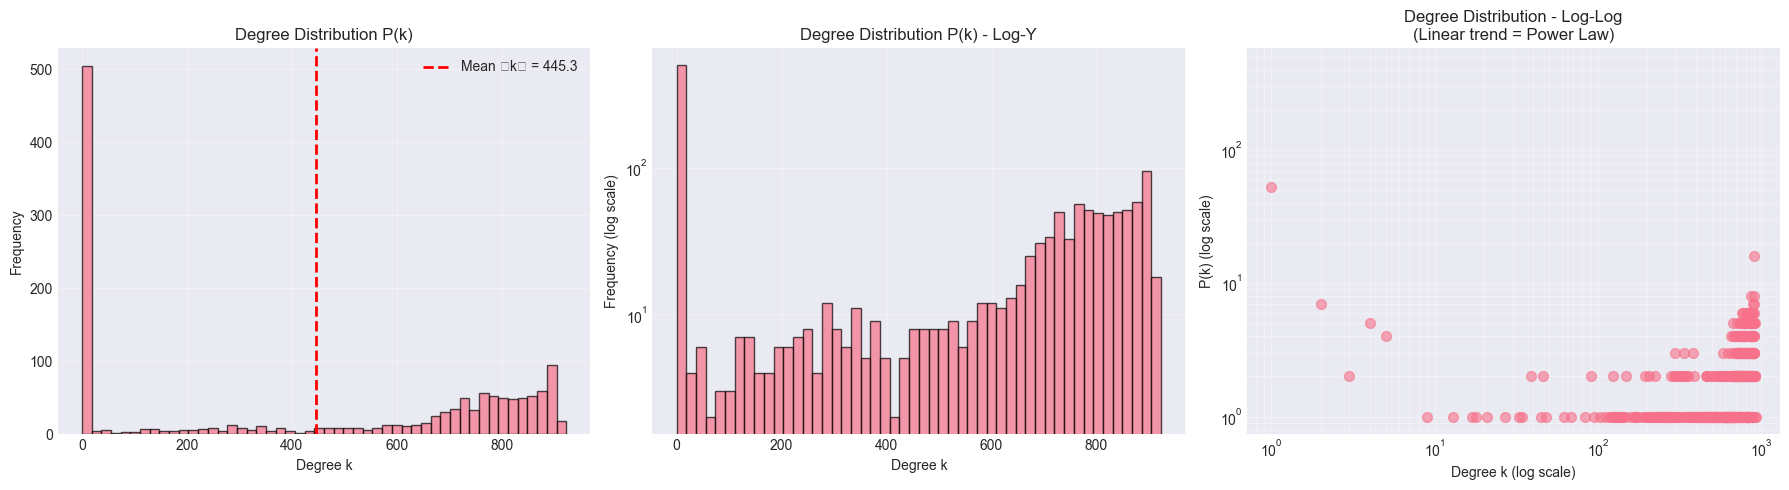


Interpretation:
  • If log-log plot is roughly linear → Power-law (scale-free network)
  • If bell-shaped on linear scale → Random-like (Poisson)
  • If heavy right tail → Few hubs, many low-degree nodes


In [5]:
# Compute degrees
degrees = dict(G.degree())
degree_values = list(degrees.values())

print("Degree Statistics:")
print("="*70)
print(f"  Mean degree ⟨k⟩:  {np.mean(degree_values):.2f}")
print(f"  Median degree:    {np.median(degree_values):.0f}")
print(f"  Max degree:       {np.max(degree_values)}")
print(f"  Min degree:       {np.min(degree_values)}")
print(f"  Std deviation:    {np.std(degree_values):.2f}")

# Degree distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear scale
axes[0].hist(degree_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree k')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution P(k)')
axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', 
                linewidth=2, label=f'Mean ⟨k⟩ = {np.mean(degree_values):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log-Y scale
axes[1].hist(degree_values, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Degree k')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution P(k) - Log-Y')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

# Log-Log scale (check for power law)
degree_counts = np.bincount(degree_values)
degrees_unique = np.arange(len(degree_counts))
mask = degree_counts > 0

axes[2].scatter(degrees_unique[mask], degree_counts[mask], alpha=0.6, s=50)
axes[2].set_xlabel('Degree k (log scale)')
axes[2].set_ylabel('P(k) (log scale)')
axes[2].set_title('Degree Distribution - Log-Log\n(Linear trend = Power Law)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • If log-log plot is roughly linear → Power-law (scale-free network)")
print("  • If bell-shaped on linear scale → Random-like (Poisson)")
print("  • If heavy right tail → Few hubs, many low-degree nodes")

## 5. Clustering Coefficient C

**Clustering coefficient** measures how much nodes cluster together.

**Local clustering C_i:** For node i, what fraction of its neighbors are also neighbors?
- C_i = (# of triangles involving i) / (# of possible triangles)

**Global clustering C:** Average over all nodes

**Interpretation:**
- C close to 1: Highly clustered (cliques)
- C close to 0: No clustering (tree-like)
- Compare to random network: C_random ≈ ⟨k⟩ / N

Computing clustering coefficient...

Clustering Coefficient:
  Average clustering C:     0.6046
  Expected for random:      0.3156
  Ratio C / C_random:       1.92x

  ✓ Higher than random → Some clustering present


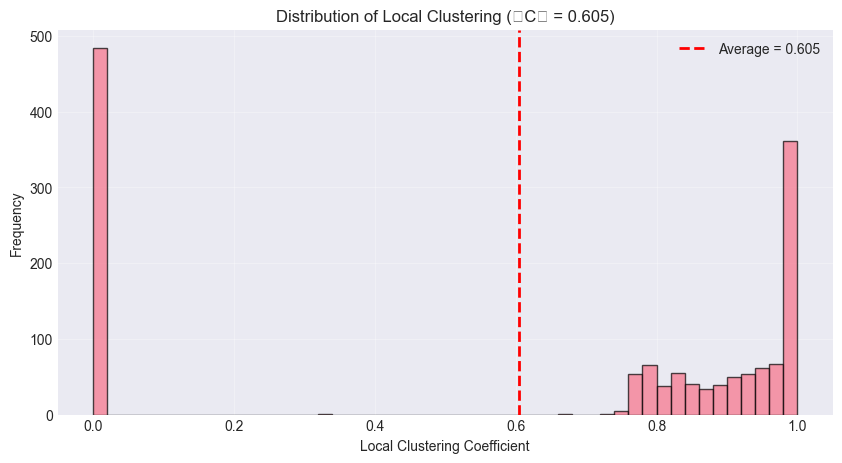

In [6]:
# Compute clustering coefficient
print("Computing clustering coefficient...")
C = nx.average_clustering(G)
C_random = np.mean(degree_values) / G.number_of_nodes()  # Expected for random network

print("\nClustering Coefficient:")
print("="*70)
print(f"  Average clustering C:     {C:.4f}")
print(f"  Expected for random:      {C_random:.4f}")
print(f"  Ratio C / C_random:       {C / C_random:.2f}x")

if C > 2 * C_random:
    print("\n  ✓ Much higher than random → Network has community structure!")
elif C > C_random:
    print("\n  ✓ Higher than random → Some clustering present")
else:
    print("\n  → Similar to random network")

# Local clustering distribution
local_clustering = nx.clustering(G)
local_clustering_values = list(local_clustering.values())

plt.figure(figsize=(10, 5))
plt.hist(local_clustering_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.title(f'Distribution of Local Clustering (⟨C⟩ = {C:.3f})')
plt.axvline(C, color='red', linestyle='--', linewidth=2, label=f'Average = {C:.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 6. Path Lengths and Small-World Property

**Average shortest path length L:** Average number of steps to get from any node to any other.

**Small-world property:** L ~ log(N)
- Short paths despite large network size
- Typical in social networks

**Diameter:** Longest shortest path in the network

Note: Only computed for connected networks (or largest component)

In [7]:
if nx.is_connected(G_main):
    print("Computing path lengths...")
    print("(This may take a minute for large networks)\n")
    
    L = nx.average_shortest_path_length(G_main)
    diameter = nx.diameter(G_main)
    
    # Expected path length for random network
    L_random = np.log(G_main.number_of_nodes()) / np.log(np.mean(degree_values))
    
    print("Path Length Statistics:")
    print("="*70)
    print(f"  Average shortest path L:  {L:.3f}")
    print(f"  Diameter (max path):      {diameter}")
    print(f"  Expected for random:      {L_random:.3f}")
    print(f"  Network size N:           {G_main.number_of_nodes():,}")
    print(f"  log(N):                   {np.log(G_main.number_of_nodes()):.3f}")
    
    # Small-world check
    print(f"\n  Small-world check:")
    print(f"    L ~ log(N)? {L:.2f} vs {np.log(G_main.number_of_nodes()):.2f}")
    if L < 2 * np.log(G_main.number_of_nodes()):
        print(f"    ✓ YES - Short path length (small-world property)")
    
    if C > 2 * C_random and L < 2 * np.log(G_main.number_of_nodes()):
        print(f"\n  🌟 SMALL-WORLD NETWORK: High clustering + Short paths!")
    
else:
    print("Network is disconnected - path metrics computed on largest component")
    print(f"Largest component size: {G_main.number_of_nodes()} / {G.number_of_nodes()} nodes")

Computing path lengths...
(This may take a minute for large networks)

Path Length Statistics:
  Average shortest path L:  1.333
  Diameter (max path):      5
  Expected for random:      1.125
  Network size N:           955
  log(N):                   6.862

  Small-world check:
    L ~ log(N)? 1.33 vs 6.86
    ✓ YES - Short path length (small-world property)


## 7. Centrality: Finding Important Nodes

**Centrality measures** identify the most important/influential users.

### Types:
1. **Degree centrality:** Most connections (popular)
2. **Betweenness centrality:** Lies on many shortest paths (bridge)
3. **Closeness centrality:** Closest to all others on average (quick access)
4. **PageRank:** Importance based on neighbors' importance (Google's algorithm)

In [8]:
print("Computing centrality measures...")
print("(Betweenness may take a minute)\n")

# Degree centrality (fast)
degree_cent = nx.degree_centrality(G)

# Betweenness centrality (slower)
betweenness = nx.betweenness_centrality(G)

# Closeness centrality (fast if connected)
closeness = nx.closeness_centrality(G)

# PageRank (fast)
pagerank = nx.pagerank(G)

print("Centrality computed!\n")

# Find top users by each metric
top_n = 10

print(f"Top {top_n} Users by Different Centrality Measures:")
print("="*70)

print(f"\nDegree Centrality (Most connected):")
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:top_n]
for i, (user, score) in enumerate(top_degree, 1):
    print(f"  {i:2d}. User {user}: {score:.4f} (degree = {degrees[user]})")

print(f"\nBetweenness Centrality (Best bridges):")
top_between = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]
for i, (user, score) in enumerate(top_between, 1):
    print(f"  {i:2d}. User {user}: {score:.4f}")

print(f"\nPageRank (Most influential):")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:top_n]
for i, (user, score) in enumerate(top_pagerank, 1):
    print(f"  {i:2d}. User {user}: {score:.4f}")

# Visualize centrality distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(list(degree_cent.values()), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Degree Centrality')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Degree Centrality Distribution')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(list(betweenness.values()), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Betweenness Centrality')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Betweenness Centrality Distribution')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(list(closeness.values()), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Closeness Centrality')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Closeness Centrality Distribution')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(list(pagerank.values()), bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('PageRank')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('PageRank Distribution')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Computing centrality measures...
(Betweenness may take a minute)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\danie\AppData\Local\Temp\ipykernel_33156\4126688267.py", line 11, in <module>
    closeness = nx.closeness_centrality(G)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\utils\decorators.py", line 784, in func
    return argmap._lazy_compile(__wrapper)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 55", line 3, in argmap_closeness_centrality_52
    import gzip
            ^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\utils\backends.py", line 535, in _call_if_no_backends_installed
    return self.orig_func(*args, **kwargs)
 

## 8. Community Detection

**Community detection** finds groups of densely connected nodes.

**Algorithm:** Louvain method (optimizes modularity)

**Modularity Q:** Measures quality of community partition
- Q ∈ [-0.5, 1]
- Q > 0.3: Good community structure
- Q > 0.7: Very strong communities

Detecting communities using Louvain algorithm...

Community Detection Results:
  Number of communities: 446
  Modularity Q:          0.0490
  → Weak community structure

Community sizes:
  Largest:  501 nodes
  Smallest: 1 nodes
  Mean:     3.2 nodes
  Median:   1 nodes

Top 10 largest communities:
   1.  501 nodes (35.5%)
   2.  448 nodes (31.8%)
   3.    4 nodes (0.3%)
   4.    3 nodes (0.2%)
   5.    2 nodes (0.1%)
   6.    2 nodes (0.1%)
   7.    2 nodes (0.1%)
   8.    2 nodes (0.1%)
   9.    2 nodes (0.1%)
  10.    2 nodes (0.1%)


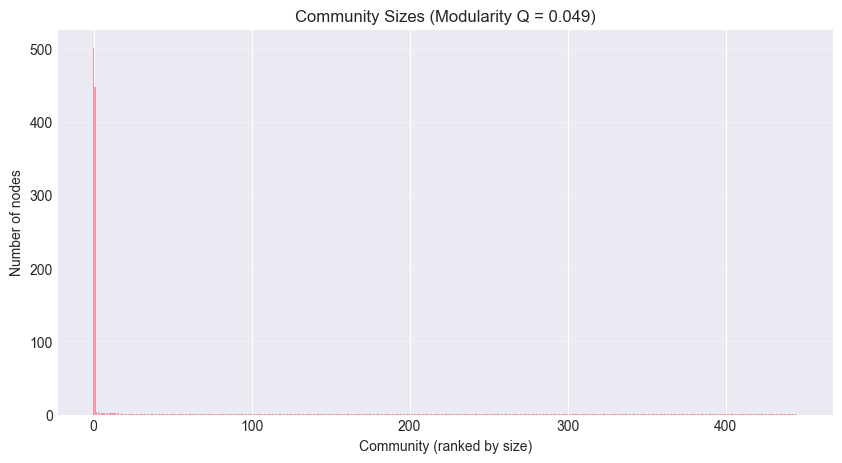

In [ ]:
print("Detecting communities using Louvain algorithm...\n")

from networkx.algorithms import community as nx_community

# Louvain community detection
communities = nx_community.louvain_communities(G)

# Compute modularity
modularity = nx_community.modularity(G, communities)

print("Community Detection Results:")
print("="*70)
print(f"  Number of communities: {len(communities)}")
print(f"  Modularity Q:          {modularity:.4f}")

if modularity > 0.7:
    print(f"  ✓ Very strong community structure!")
elif modularity > 0.3:
    print(f"  ✓ Good community structure")
else:
    print(f"  → Weak community structure")

# Analyze community sizes
community_sizes = [len(c) for c in communities]
community_sizes.sort(reverse=True)

print(f"\nCommunity sizes:")
print(f"  Largest:  {community_sizes[0]} nodes")
print(f"  Smallest: {community_sizes[-1]} nodes")
print(f"  Mean:     {np.mean(community_sizes):.1f} nodes")
print(f"  Median:   {np.median(community_sizes):.0f} nodes")

print(f"\nTop 10 largest communities:")
for i, size in enumerate(community_sizes[:10], 1):
    print(f"  {i:2d}. {size:4d} nodes ({100*size/G.number_of_nodes():.1f}%)")

# Visualize community size distribution
plt.figure(figsize=(10, 5))
plt.bar(range(len(community_sizes)), community_sizes, alpha=0.7)
plt.xlabel('Community (ranked by size)')
plt.ylabel('Number of nodes')
plt.title(f'Community Sizes (Modularity Q = {modularity:.3f})')
plt.grid(alpha=0.3, axis='y')
plt.show()

## 9. Summary: Network Characterization

Compare your network to theoretical models:

In [ ]:
print("="*70)
print("NETWORK CHARACTERIZATION SUMMARY")
print("="*70)

print(f"\nBasic Properties:")
print(f"  Nodes (N):            {G.number_of_nodes():,}")
print(f"  Edges (E):            {G.number_of_edges():,}")
print(f"  Average degree ⟨k⟩:   {np.mean(degree_values):.2f}")
print(f"  Density:              {nx.density(G):.4f}")

print(f"\nStructural Properties:")
print(f"  Clustering C:         {C:.4f} (random: {C_random:.4f}, ratio: {C/C_random:.1f}x)")
if nx.is_connected(G_main):
    print(f"  Avg path length L:    {L:.3f} (compare to log(N) = {np.log(G.number_of_nodes()):.2f})")
    print(f"  Diameter:             {diameter}")

print(f"\nCommunity Structure:")
print(f"  Communities:          {len(communities)}")
print(f"  Modularity Q:         {modularity:.4f}")

print(f"\nNetwork Type Assessment:")
print(f"  → Check degree distribution plot (log-log):")
print(f"      Linear trend = Scale-free (power-law)")
print(f"      Bell-shaped = Random-like")

if C > 2 * C_random:
    print(f"  ✓ High clustering → Not random")
    
if nx.is_connected(G_main) and L < 2 * np.log(G.number_of_nodes()):
    print(f"  ✓ Short paths → Small-world property")

if C > 2 * C_random and (nx.is_connected(G_main) and L < 2 * np.log(G.number_of_nodes())):
    print(f"\n  🌟 LIKELY A SMALL-WORLD NETWORK")
    print(f"     (High clustering + Short paths)")

if modularity > 0.3:
    print(f"  ✓ Strong communities detected")

print("\n" + "="*70)

NETWORK CHARACTERIZATION SUMMARY

Basic Properties:
  Nodes (N):            1,411
  Edges (E):            314,150
  Average degree ⟨k⟩:   445.29
  Density:              0.3158

Structural Properties:
  Clustering C:         0.6046 (random: 0.3156, ratio: 1.9x)
  Avg path length L:    1.333 (compare to log(N) = 7.25)
  Diameter:             5

Community Structure:
  Communities:          446
  Modularity Q:         0.0490

Network Type Assessment:
  → Check degree distribution plot (log-log):
      Linear trend = Scale-free (power-law)
      Bell-shaped = Random-like
  ✓ Short paths → Small-world property



## 10. Build Network with Weights

Create weighted graph using cosine similarity as weights, to use for SIR modeling.

In [9]:
print(f"Building network with cosine similarity weights.")
print("="*70)

# Create graph
G = nx.Graph()

# Add all users as nodes
users = user_video_matrix.index.tolist()
G.add_nodes_from(users)
print(f"Added {G.number_of_nodes():,} nodes")

# Add edges for user pairs with similarity > threshold
edges_added = 0
for i, user_i in enumerate(users):
    for j, user_j in enumerate(users[i+1:], start=i+1):  # Only upper triangle (undirected)
        sim = similarity_df.loc[user_i, user_j]
        G.add_edge(user_i, user_j, weight=sim)
        edges_added += 1

print(f"Added {edges_added:,} edges")

# Network statistics
N = G.number_of_nodes()
E = G.number_of_edges()
max_edges = N * (N - 1) / 2
density = nx.density(G)

print(f"\nNetwork Properties:")
print(f"  Nodes (N):        {N:,}")
print(f"  Edges (E):        {E:,}")
print(f"  Density:          {density:.4f} ({100*density:.2f}%)")
print(f"  Max possible edges: {int(max_edges):,}")
print(f"  Is connected:     {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    largest_cc = max(components, key=len)
    print(f"  Components:       {len(components)}")
    print(f"  Largest component: {len(largest_cc)} nodes ({100*len(largest_cc)/N:.1f}%)")
    print(f"\n  → Working with largest connected component for path-based metrics")
    G_main = G.subgraph(largest_cc).copy()
else:
    G_main = G

Building network with cosine similarity weights.
Added 1,411 nodes
Added 994,755 edges

Network Properties:
  Nodes (N):        1,411
  Edges (E):        994,755
  Density:          1.0000 (100.00%)
  Max possible edges: 994,755
  Is connected:     True


## 11. Strength Distribution S(k)

The strength distribution shows how much connection weight each node has.

**Key patterns:**
- **Poisson (random network):** Bell-shaped, most nodes have degree ≈ ⟨k⟩
- **Power-law (scale-free):** P(k) ~ k^(-γ), few hubs with strong connections
- **Heavy-tailed:** Between random and power-law

**Check:** Plot on log-log scale. Linear = power-law.

Strength Statistics:
  Mean strength ⟨s⟩:  805.12
  Median strength:    869
  Max strength:       1061.7961955039198
  Min strength:       120.84895451485319
  Std deviation:    199.65


C:\Users\danie\AppData\Local\Temp\ipykernel_33156\705459893.py:45: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\danie\AppData\Local\Temp\ipykernel_33156\705459893.py:45: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()


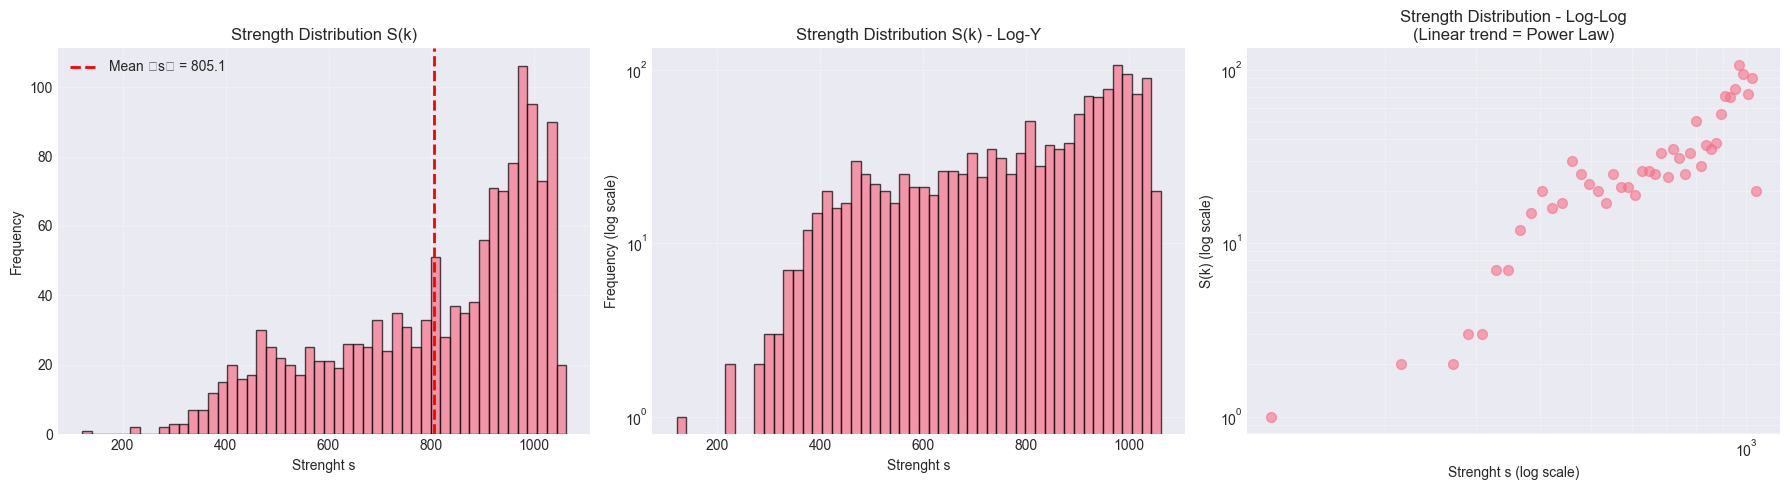


Interpretation:
  • If log-log plot is roughly linear → Power-law (scale-free network)
  • If bell-shaped on linear scale → Random-like (Poisson)
  • If heavy right tail → Few hubs, many low-degree nodes


In [10]:
# Compute strengths
strength = dict(G.degree(weight='weight'))
strength_values = list(strength.values())

print("Strength Statistics:")
print("="*70)
print(f"  Mean strength ⟨s⟩:  {np.mean(strength_values):.2f}")
print(f"  Median strength:    {np.median(strength_values):.0f}")
print(f"  Max strength:       {np.max(strength_values)}")
print(f"  Min strength:       {np.min(strength_values)}")
print(f"  Std deviation:    {np.std(strength_values):.2f}")

# Strength distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear scale
axes[0].hist(strength_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Strenght s')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Strength Distribution S(k)')
axes[0].axvline(np.mean(strength_values), color='red', linestyle='--', 
                linewidth=2, label=f'Mean ⟨s⟩ = {np.mean(strength_values):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log-Y scale
axes[1].hist(strength_values, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Strenght s')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Strength Distribution S(k) - Log-Y')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

# Log-Log scale (check for power law)
strength_counts, bin_edges = np.histogram(strength_values, 50)

axes[2].scatter(bin_edges[:-1], strength_counts, alpha=0.6, s=50)
axes[2].set_xlabel('Strenght s (log scale)')
axes[2].set_ylabel('S(k) (log scale)')
axes[2].set_title('Strength Distribution - Log-Log\n(Linear trend = Power Law)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • If log-log plot is roughly linear → Power-law (scale-free network)")
print("  • If bell-shaped on linear scale → Random-like (Poisson)")
print("  • If heavy right tail → Few hubs, many low-degree nodes")